In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import string
import nltk
import logic.processing as lp
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Flotchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Flotchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Flotchi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Flotchi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/Flotchi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [78]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Flotchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Flotchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Flotchi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Flotchi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/Flotchi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [86]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
path = os.getcwd()

In [4]:
rpath = os.path.join(os.path.dirname(path),'raw_data', 'drugsComTrain_raw.csv') 

In [5]:
df = pd.read_csv(rpath)

In [6]:
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [7]:
df.shape

(161297, 7)

In [8]:
df.isnull().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [17]:
df[[('drugName')]].value_counts()

drugName                         
Levonorgestrel                       3657
Etonogestrel                         3336
Ethinyl estradiol / norethindrone    2850
Nexplanon                            2156
Ethinyl estradiol / norgestimate     2117
                                     ... 
Fludarabine                             1
Fludara                                 1
FluMist Quadrivalent                    1
Floxin                                  1
A + D Cracked Skin Relief               1
Name: count, Length: 3436, dtype: int64

In [11]:
condition_distribution = df['drugName'].value_counts()

num_non_null_conditions = df['drugName'].notnull().sum()

proportion_defined_conditions = num_non_null_conditions / len(df) * 100

num_non_null_conditions, proportion_defined_conditions

(161297, 100.0)

In [12]:
top_conditions = condition_distribution.head(10)

In [14]:
top_conditions_list = top_conditions.index.tolist()
top_conditions_list

['Levonorgestrel',
 'Etonogestrel',
 'Ethinyl estradiol / norethindrone',
 'Nexplanon',
 'Ethinyl estradiol / norgestimate',
 'Ethinyl estradiol / levonorgestrel',
 'Phentermine',
 'Sertraline',
 'Escitalopram',
 'Mirena']

1. Filtrer top 10 conditions
2. DropNA
3. Filtrer top usefulcount
4. Filtrer review len < X

In [15]:
df_top10 = df[df['drugName'].isin(top_conditions_list)]

In [16]:
df_top10.shape

(21441, 7)

In [50]:
df_top10 = df_top10.dropna()

In [51]:
df_top10.shape

(73951, 7)

In [56]:
df_top10 = df_top10[df_top10['usefulCount']>0]

In [57]:
df_top10.shape

(70543, 7)

In [66]:
len(df_top10.review.iloc[1])

755

In [68]:
len(df_top10.review.iloc[1].split())

134

In [69]:
df_top10['review_length'] = df_top10['review'].apply(lambda x: len(str(x).split()))

In [70]:
review_length_distribution = df_top10['review_length'].describe()

In [71]:
review_length_distribution

count    70543.000000
mean        91.194888
std         43.440591
min          1.000000
25%         57.000000
50%         94.000000
75%        130.000000
max       1107.000000
Name: review_length, dtype: float64

(array([4.3070e+04, 2.7361e+04, 7.1000e+01, 2.1000e+01, 9.0000e+00,
        8.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.000e+00, 1.116e+02, 2.222e+02, 3.328e+02, 4.434e+02, 5.540e+02,
        6.646e+02, 7.752e+02, 8.858e+02, 9.964e+02, 1.107e+03]),
 <BarContainer object of 10 artists>)

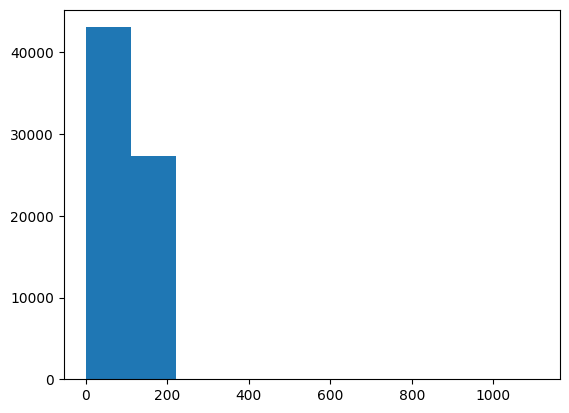

In [74]:
plt.hist(df_top10['review_length'])

In [75]:
df_top10 = df_top10[df_top10.review_length>=30]

In [76]:
df_top10.shape

(63888, 8)

In [87]:
def process(st):
        for punc in string.punctuation:
            st = st.replace(punc, '')
        ans = st.casefold().replace('\n', ' ')
        ansd = ''.join(x for x in ans if not x.isdigit())
        stop = set(stopwords.words('english'))
        tokens = word_tokenize(ansd)
        ansdd = [y for y in tokens if y not in stop]
        lemmaverb = [WordNetLemmatizer().lemmatize(word, pos='v') for word in ansdd]
        lemmanouns = [WordNetLemmatizer().lemmatize(word, pos='n') for word in lemmaverb]
        nans = ' '.join(lemmanouns)
        return nans

In [88]:
df_top10['review clean'] = df_top10.review.apply(process)

In [89]:
df_top10.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_length,review clean
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,141,son halfway fourth week intuniv become concern...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,134,use take another oral contraceptive pill cycle...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,89,first time use form birth control im glad go p...
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32,146,abilify change life hope zoloft clonidine firs...
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1,142,pill many year doctor change rx chateal effect...


In [93]:
X = df_top10['review clean']
y = df_top10['condition']

In [144]:
pipeline = make_pipeline(TfidfVectorizer(),
                         MultinomialNB())

In [96]:
cross_val = cross_validate(pipeline,X,y, cv=5, scoring='accuracy')

In [99]:
cross_val['test_score'].mean()

0.8724017086726737

In [104]:
y_pred = cross_val_predict(pipeline, X, y, cv=5)
cm = confusion_matrix(y, y_pred)

KeyboardInterrupt: 

<Figure size 1000x800 with 0 Axes>

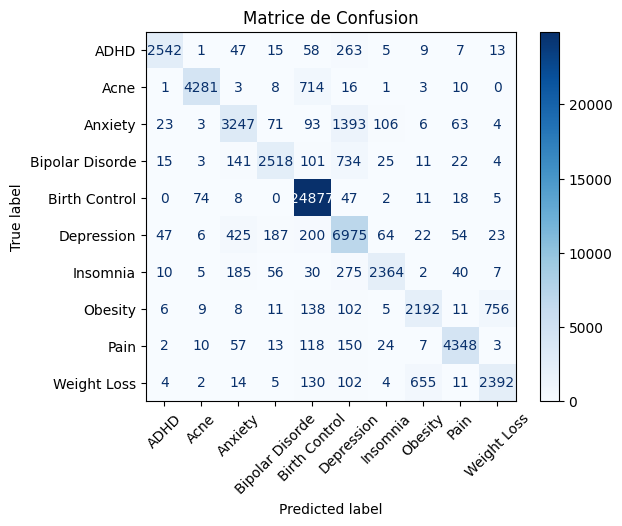

In [105]:
plt.figure(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
cm_display.plot(cmap='Blues', xticks_rotation=45)
plt.title('Matrice de Confusion')
plt.show()

In [106]:
pipeline.fit(X,y)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_df=0.9)),
                ('multinomialnb', MultinomialNB(alpha=0.01))])

In [124]:
new_review = ["i'm feel like life has no sense"]

In [125]:
prediction = pipeline.predict(new_review)

In [126]:
prediction

array(['Bipolar Disorde'], dtype='<U15')

GridSearch

In [150]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [151]:
param_grid = {
    'tfidf__max_df': [0.75, 1.0],  # Ignore les termes présents dans plus de x% des documents
    'tfidf__min_df': [1, 2, 5],   # Ignore les termes présents dans moins de x documents
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams ou bigrams
    'nb__alpha': [0.1, 1.0, 10.0]  # Laplace smoothing
}

In [152]:
# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)

In [153]:
grid_search.fit(X,y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.1, 1.0, 10.0],
                         'tfidf__max_df': [0.75, 1.0],
                         'tfidf__min_df': [1, 2, 5],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=3)

In [154]:
grid_search.best_score_

0.9016403504139472

In [155]:
grid_search.best_params_

{'nb__alpha': 0.1,
 'tfidf__max_df': 0.75,
 'tfidf__min_df': 5,
 'tfidf__ngram_range': (1, 2)}

In [156]:
best_model = grid_search.best_estimator_

In [160]:
y_pred = best_model.predict(X)

In [161]:
cm = confusion_matrix(y, y_pred)

<Figure size 1000x800 with 0 Axes>

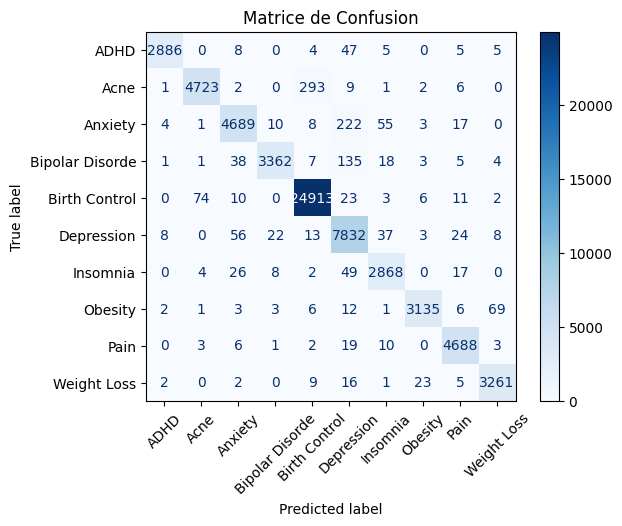

[CV 3/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.863 total time=   7.7s
[CV 2/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.861 total time=  17.5s
[CV 2/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.861 total time=   6.9s
[CV 5/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.864 total time=   7.3s
[CV 2/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.880 total time=  19.2s
[CV 1/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1);, score=0.865 total time=   8.3s
[CV 4/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1);, score=0.861 total time=   6.8s
[CV 2/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2);, score=0.902 total time=  14.8s
[CV 1/5]

[CV 4/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.862 total time=   7.8s
[CV 3/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.870 total time=  17.1s
[CV 5/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.865 total time=  19.8s
[CV 4/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.883 total time=  20.4s
[CV 3/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1);, score=0.864 total time=   6.9s
[CV 1/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2);, score=0.903 total time=  15.1s
[CV 5/5] END nb__alpha=0.1, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2);, score=0.901 total time=  13.6s
[CV 2/5] END nb__alpha=0.1, tfidf__max_df=1.0, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.861 total time=  16.8s
[CV 1/5] 

In [162]:
plt.figure(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
cm_display.plot(cmap='Blues', xticks_rotation=45)
plt.title('Matrice de Confusion')
plt.show()

In [179]:
new_sent = ["life has no sense"]

In [180]:
new_pred = best_model.predict(new_sent)

In [181]:
new_pred

array(['Depression'], dtype='<U15')

Let's try others ML models

In [188]:
pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))),
    ('SVM', SVC())
])

In [189]:
cv = cross_validate(pipeline2,X,y, cv=2, scoring='accuracy')

In [190]:
cv['test_score'].mean()

0.8948941898322064

In [196]:
pipeline3 = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('rf', RandomForestClassifier())
])

In [194]:
cv = cross_validate(pipeline3,X,y, cv=2, scoring='accuracy')

In [195]:
cv['test_score'].mean()

0.8711964688204358

In [202]:
# Paramètres à tester
param_grid = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__min_df': [1,2,5],
    'rf__n_estimators': [100, 200],  # Nombre d'arbres
    'rf__max_depth': [10, 20],  # Profondeur maximale
}

# GridSearchCV
grid_search = GridSearchCV(pipeline3, param_grid, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X, y)

# Résultats
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'rf__max_depth': 20, 'rf__n_estimators': 100, 'tfidf__max_df': 0.75, 'tfidf__min_df': 5}
Best Cross-Validation Score: 0.5316647883796645


In [203]:
grid_search.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))),
                ('rf', RandomForestClassifier(max_depth=20))])

[CV 2/2] END rf__max_depth=10, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.75, tfidf__min_df=1;, score=0.392 total time=  45.2s
[CV 1/2] END rf__max_depth=10, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=1.0, tfidf__min_df=2;, score=0.392 total time=  32.6s
[CV 2/2] END rf__max_depth=10, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.75, tfidf__min_df=1;, score=0.392 total time=  40.9s
[CV 2/2] END rf__max_depth=10, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=1.0, tfidf__min_df=2;, score=0.392 total time=  39.2s
[CV 2/2] END rf__max_depth=20, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.75, tfidf__min_df=2;, score=0.429 total time=  36.0s
[CV 2/2] END rf__max_depth=20, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=1.0, tfidf__min_df=1;, score=0.403 total time=  53.1s
[CV 1/2] END rf__max_depth=20, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.75, tfidf__min_df=2;, score

[CV 1/2] END rf__max_depth=10, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.75, tfidf__min_df=1;, score=0.392 total time=  45.9s
[CV 2/2] END rf__max_depth=10, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=1.0, tfidf__min_df=2;, score=0.392 total time=  32.5s
[CV 1/2] END rf__max_depth=10, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.75, tfidf__min_df=2;, score=0.392 total time=  32.6s
[CV 1/2] END rf__max_depth=10, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=1.0, tfidf__min_df=1;, score=0.392 total time=  45.6s
[CV 1/2] END rf__max_depth=20, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=0.75, tfidf__min_df=1;, score=0.399 total time=  44.2s
[CV 1/2] END rf__max_depth=20, rf__min_samples_split=2, rf__n_estimators=100, tfidf__max_df=1.0, tfidf__min_df=2;, score=0.423 total time=  42.6s
[CV 1/2] END rf__max_depth=20, rf__min_samples_split=2, rf__n_estimators=200, tfidf__max_df=0.75, tfidf__min_df=1;, score